In [0]:
from __future__ import print_function
from scipy.io import loadmat
from tqdm import tqdm
from google.colab import drive
import numpy as np
import scipy
import os

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir('/content/gdrive/My Drive/Independent Study')
# os.listdir('./')

In [0]:
annots = loadmat('./mydata/2014.mat')
data = annots['data']
data = np.array(data)

In [7]:
data.shape


(135, 129, 365)

In [0]:
data = data[4:125,4:125]

In [0]:
shapefile = loadmat('india_regional_grid.mat')
shapefile = shapefile['grid']  # 121x121 grid India file

In [0]:
# print(shapefile[51][92])

In [0]:
# c=0
# d=0
# for i in shapefile:
#   for j in i:
#     if j == 1:
#       c+=1
#     else: 
#       d+=1
# print(c," ",d)

In [0]:
def shapeTransform(filename):
    annots = loadmat(filename)
    data = annots['data']
    data = np.array(data)
    data = data[4:125,4:125]
    # print(data[60][60][200])
    return data


years = []
resized_data = []
for i in range(1901,2019):
	years.append("./mydata/"+str(i)+".mat")

for i in years:
	resized_data.append(shapeTransform(i))



In [0]:
def is_leap_year(year):
    leap_year_months = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    not_leap_year_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    if (year % 4) == 0:
        if (year % 100) == 0:
            if (year % 400) == 0:
                return True, leap_year_months
            else:
                return False, not_leap_year_months
        else:
            return True, leap_year_months
    else:
        return False, not_leap_year_months

In [0]:
def calc_max(year):
    c=0
    dt = np.array(resized_data[year-1901]);
    month_days = is_leap_year(year);
    max_ind = np.zeros((121,121,12))
    max_ind.fill(-1)
    for i in range(121):
        for j in range(121):
            if not shapefile[i,j]:
                c+=1
                continue
            cnt=0
            for k in range(len(month_days[1])):
                a = dt[:,:,cnt:cnt+month_days[1][k]]
                max_val = np.max(a[i][j])
                max_ind[i][j][k] = max_val;
                cnt=cnt+month_days[1][k]
    # return c
    return max_ind

In [0]:
def Rnnmm_calcuate(year,n):
    dt = np.array(resized_data[year-1901]);
    Rnnmm = np.zeros((121,121))
    for i in range(121):
        for j in range(121):
          c=0
          if not shapefile[i,j]:
              continue
          for k in dt[i][j]:
            if k>=n:
              c+=1
          Rnnmm[i][j] = c;
    return Rnnmm

In [0]:
# CDD. Maximum length of dry spell, maximum number of consecutive days with RR < 1mm &&
# CWD. Maximum length of wet spell, maximum number of consecutive days with RR ≥ 1mm: Calculations

def dry_wet_spell(year):
    dt = np.array(resized_data[year-1901]);
    dry = np.zeros((121,121))
    wet = np.zeros((121,121)) 
    for i in range(121):
        for j in range(121):
          maxDry = 0
          maxWet = 0
          cDry=0
          cWet=0
          flag=0
          if not shapefile[i,j]:
              continue
          for rainfall in dt[i][j]:
            if rainfall<1 and rainfall>=0:
              cDry+=1
              maxWet=max(maxWet,cWet)
              cWet=0
            if rainfall<0:
              maxWet = -1
              maxDry = -1
            if rainfall>=1:
              cWet+=1
              maxDry=max(maxDry,cDry)
              cDry=0
          maxDry=max(maxDry,cDry)
          maxWet=max(maxWet,cWet)
          # print(maxDry)
          dry[i][j] = maxDry;
          wet[i][j] = maxWet;
    return dry,wet

In [0]:
def calc_RX5_max(year):
    c=0
    dt = np.array(resized_data[year-1901]);
    month_days = is_leap_year(year);
    max_ind = np.zeros((121,121,12))
    max_ind.fill(-1)
    for i in range(121):
        for j in range(121):
            if not shapefile[i,j]:
                c+=1
                continue
            cnt=0
            for k in range(len(month_days[1])):
                a = dt[:,:,cnt:cnt+month_days[1][k]]
                arrPeryear = a[i][j]
                max_val=0
                ind=0
                for l in range(len(arrPeryear)-4):
                    max_val = max(max_val,np.sum(arrPeryear[ind:ind+5]));
                    ind = ind + 1
                max_ind[i][j][k] = max_val;
                cnt=cnt+month_days[1][k]
    return max_ind

In [0]:
# PRCPTOT Calculation - . Annual total precipitation in wet days:

def prcptot(year):
    dt = np.array(resized_data[year-1901]);
    total = np.zeros((121,121))
    
    for i in range(121):
        for j in range(121):
          wetRainfall = 0
          if not shapefile[i,j]:
              continue
          for rainfall in dt[i][j]:
            if rainfall>=1:
              wetRainfall+=rainfall
          total[i][j] = wetRainfall;
    return total

In [0]:
def percentile95(year):
    dt = np.array(resized_data[year-1901]);
    total = np.zeros((121,121))
    for i in range(121):
        for j in range(121):
            if not shapefile[i,j]:
                continue
            val = np.percentile(dt[i][j], 95)
            tt = 0
            if(val<0):
                total[i][j]=-1
            for rainfall in dt[i][j]:
                if(val<rainfall):
                    tt = tt + val
            total[i][j]=tt
    return total

In [0]:
def percentile99(year):
    dt = np.array(resized_data[year-1901]);
    total = np.zeros((121,121))
    for i in range(121):
        for j in range(121):
            if not shapefile[i,j]:
                continue
            val = np.percentile(dt[i][j], 99)
            tt = 0
            if(val<0):
                total[i][j]=-1
            for rainfall in dt[i][j]:
                if(val<rainfall):
                    tt = tt + val
            total[i][j]=tt
    return total

In [0]:
## SDII Simple pricipitation intensity index: Let RRwj be the daily precipitation amount on wet days

def sdii(year):
    dt = np.array(resized_data[year-1901]);
    total = np.zeros((121,121))
    for i in range(121):
        for j in range(121):
          wetRainfall = 0
          no_wetdays = 0
          if not shapefile[i,j]:
              continue
          for rainfall in dt[i][j]:
            if rainfall>=1:
              wetRainfall+=rainfall
              no_wetdays +=1
          if(no_wetdays==0):
            if(dt[i][j][0] == -999):
              total[i][j]=-1
            else:
              total[i][j]=0
          else:
            total[i][j] = wetRainfall/no_wetdays;
    return total

In [0]:
# sdii(1901)

In [0]:
# Calcuating 1st Precipitation Index Rx1day
Rx1day = []
for year in range(1901,2019):
    max_ind = calc_max(year)
    Rx1day.append(max_ind)

In [0]:
# Calcuating Precipitation Index Rx5day
Rx5day = []
for year in range(1901,2019):
    max_ind = calc_RX5_max(year)
    Rx5day.append(max_ind)

In [0]:
# Calcuating 4th Precipitation Index R10mm
R10mm = []
for year in range(1901,2019):
    max_ind = Rnnmm_calcuate(year,10)
    R10mm.append(max_ind)

In [0]:
R20mm = []
for year in range(1901,2019):
    max_ind = Rnnmm_calcuate(year,20)
    R20mm.append(max_ind)

In [0]:
R25mm = []
for year in range(1901,2019):
    max_ind = Rnnmm_calcuate(year,25)
    R25mm.append(max_ind)

In [0]:
PRCPTOT = []
for year in range(1901,2019):
    max_ind = prcptot(year)
    PRCPTOT.append(max_ind)

In [0]:
SDII = []
for year in range(1901,2019):
    max_ind = sdii(year)
    SDII.append(max_ind)

In [0]:
drySpell = []
wetSpell = []
for year in range(1901,2019):
  dry, wet = dry_wet_spell(year)
  drySpell.append(dry)
  wetSpell.append(wet)

### RX1DAY = 118 yrs * 121 * 121 * 12

In [0]:
## F1 for Annual Indices Calculation

def f1(Rnmm):
    avgPerYear = np.zeros((118))
    for year in range(118):
        numPoints = 0
        yearTotal = 0
        for i in range(121):
            for j in range(121):
                if shapefile[i][j] == 1:
                  f=0
                  if(Rnmm[year][i][j]<0):
                    f+=1
                    continue
                  yearTotal += Rnmm[year][i][j]
                  if f==0: #add to num points only if Rx1day[i][j][k] > 0
                    numPoints = numPoints + 1
        avgPerYear[year]=yearTotal/numPoints
    return avgPerYear

In [0]:
def f3(Rnmm):
    avgPerYear = np.zeros((30))
    for year in range(30):
        numPoints = 0
        yearTotal = 0
        for i in range(121):
            for j in range(121):
                if shapefile[i][j] == 1:
                  f=0
                  if(Rnmm[year][i][j]<0):
                    f+=1
                    continue
                  yearTotal += Rnmm[year][i][j]
                  if f==0: #add to num points only if Rx1day[i][j][k] > 0
                    numPoints = numPoints + 1
        avgPerYear[year]=yearTotal/numPoints
    return avgPerYear

# F2

In [0]:
def f2(arr):
    avgPerYear = np.zeros((118))
    avgPerMonthPerYear = np.zeros((118,12))
    for year in range(118):
        numPoints = 0
        yearAvg = 0
        monthAvgYear = np.zeros((12))
        for i in range(121):
            for j in range(121):
                if shapefile[i][j] == 1:
                  monthAvg=0
                  length = len(arr[year][i][j])
                  f=0
                  for k in range(length):
                    if(arr[year][i][j][k]<0):
                      f+=1
                      continue
                      # print(i," ",j," ",k)
                    monthAvgYear[k] += arr[year][i][j][k]
                    monthAvg += arr[year][i][j][k]
                  monthAvg /= 12
                  if f==0: #add to num points only if Rx1day[i][j][k] > 0
                    numPoints = numPoints + 1
                  yearAvg = yearAvg + monthAvg
        
        for i in range(12):
            avgPerMonthPerYear[year][i] = monthAvgYear[i]/numPoints
        avgPerYear[year]=yearAvg/numPoints
    return avgPerYear, avgPerMonthPerYear
    

In [91]:
# Calculating rainfall foreach i,j,day,year which is greater than or equal to 1
def getRainfall(percentile):
    day_percentile = np.zeros((121,121,366,30))
    rainfall = np.zeros((121,121,366,30))
    for year in range(1961,1991):
        month_days = is_leap_year(year-1901);
        dt = np.array(resized_data[year-1901]);
        for i in range(121):
            for j in range(121):
                if not shapefile[i,j]:
                    continue
                # Not leap year
                if(len(dt[i][j]) != 366):
                    day_percentile[i][j][59][year-1961]=-1;
                flag=0;
                for k in range(len(dt[i][j])):
                    if(k==58 and len(dt[i][j]) != 366):
                        flag=1
                    if(dt[i][j][k]>=1):
                        day_percentile[i][j][k+flag][year-1961]=dt[i][j][k];
                    else:
                        day_percentile[i][j][k+flag][year-1961]=-1;
    
    rainfall  = day_percentile;
    return rainfall , dt

def getPercentileValues(percentile):
    percentile_values = np.zeros((121,121,366));
    for i in range(121):
        print(i)
        for j in range(121):
             if not shapefile[i,j]:
                    continue
             for day in range(366):
                perc = np.percentile(rainfall[i][j][day],percentile);
                percentile_values[i][j][day] = perc
    return percentile_values


def getTotalDays(percentile):
    total = np.zeros((121,121))
    for year in range(1901,2019):
        for i in range(121):
            for j in range(121):
                if not shapefile[i,j]:
                    continue
                flag=0
                for k in range(len(dt[i][j])):
                    if(k==58 and len(dt[i][j]) != 366):
                        flag=1
                    if(dt[i][j][k] > percentile_values[i][j][k+flag]):
                        total[i][j] = total[i][j] + dt[i][j][k]
    return total


rainfall , dt = getRainfall(95)
percentile_values = getPercentileValues(95)
total_95 = getTotalDays(95)

# for i in total_95:
#   print(i)

rainfall , dt = getRainfall(99)
percentile_values = getPercentileValues(99)
total_99 = getTotalDays(99)

# for i in total_99:
#   print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [0]:
R95pTOT = total_95
R99pTOT = total_99

In [0]:
avgYearly, avgYearMonthly = f2(Rx1day)

In [45]:
avgYearly

array([22.5584258 , 22.14399432, 24.71383695, 22.35536561, 21.27040014,
       24.07648043, 21.3928319 , 21.92401217, 23.4221966 , 24.95032787,
       22.49757384, 23.0390926 , 24.85599885, 25.15180787, 25.90376562,
       25.61181191, 28.41720953, 19.41896802, 24.89787015, 21.14546177,
       23.36450692, 22.74642098, 22.31328166, 24.5905536 , 22.92403391,
       23.84814004, 25.43663005, 23.72483631, 23.72406563, 25.22958243,
       24.39261878, 23.22590195, 28.82400444, 23.3359831 , 21.43871034,
       26.39036979, 25.20637565, 23.70580259, 22.53290866, 25.1992397 ,
       23.70428617, 25.13198495, 24.76458218, 26.34596326, 24.18441274,
       25.97230184, 24.28563822, 24.24747742, 23.14347263, 22.6536679 ,
       21.89493895, 21.5788986 , 22.81032219, 22.89464144, 25.05864378,
       27.11365067, 22.86537967, 25.02890436, 25.38943132, 22.28394381,
       26.34774291, 22.66547263, 23.14491145, 22.99646975, 20.78040909,
       22.69608532, 23.24720347, 22.16073549, 22.4031562 , 24.29

In [0]:
matfile = 'rx1.mat'
scipy.io.savemat(matfile, mdict={'out': Rx1day}, oned_as='row')

In [0]:
Rx5dayYearly, Rx5dayYearMonthly = f2(Rx5day)

In [48]:
Rx5dayYearly

array([42.61840923, 43.91840779, 48.93235659, 43.56649342, 41.04988139,
       49.03887669, 42.58436335, 42.78281561, 47.10351464, 50.14338539,
       44.99471449, 45.15376056, 48.23409357, 49.52551555, 50.76352225,
       51.48922664, 55.93181982, 39.25817509, 49.29087126, 42.25914876,
       48.24601727, 45.22493875, 44.33639838, 49.0563364 , 45.66881486,
       47.6696964 , 49.63382356, 46.77768922, 47.29702374, 49.44417187,
       48.50284352, 47.0389581 , 58.21757058, 47.30467674, 43.5224871 ,
       52.85921585, 48.9201844 , 47.87612605, 45.7163852 , 49.43944386,
       45.87913295, 50.49808522, 49.52574941, 51.80389967, 48.76057753,
       51.73602913, 48.66167152, 50.48005122, 47.54004784, 47.04334915,
       42.67549108, 44.23411091, 46.97874755, 46.60781361, 51.82380523,
       56.39942036, 45.85171833, 50.22642223, 51.22273661, 45.4928174 ,
       52.76523805, 45.55088248, 45.33443679, 46.624026  , 40.65413314,
       45.8310622 , 47.50908326, 44.38920222, 45.08500472, 48.90

In [0]:
matfile = 'rx5.mat'
scipy.io.savemat(matfile, mdict={'out': Rx5day}, oned_as='row')

In [0]:
R10mm_yearly  = f1(R10mm)

In [51]:
R10mm_yearly

array([30.65876878, 31.07827375, 34.84810662, 30.3645018 , 28.45123757,
       33.97376772, 30.70404062, 32.42542839, 34.60630421, 35.89422467,
       31.31394119, 32.91918765, 31.26422678, 34.28770891, 33.42521684,
       38.48423948, 42.73704252, 27.81235456, 35.63042099, 28.91622594,
       34.38227205, 34.08969748, 32.37021367, 34.43875608, 33.82441295,
       34.68817432, 33.90543685, 33.22424371, 33.64565263, 33.20287709,
       36.65284536, 33.72709964, 38.28115084, 34.76221705, 32.24941824,
       37.10514068, 33.94965094, 36.04146393, 31.05161836, 33.37507933,
       28.87687751, 35.76369791, 36.41992807, 36.5381849 , 35.11000635,
       37.29426698, 34.81912418, 37.20922361, 36.86122276, 33.63972922,
       29.72011847, 31.79077639, 34.37444468, 33.89760948, 38.0463296 ,
       39.63295959, 32.56822509, 35.2233975 , 37.6037656 , 31.98561455,
       38.04336789, 32.98561455, 33.12587265, 34.26126507, 27.13475777,
       30.18024117, 33.22995557, 29.30590226, 31.34525069, 35.12

In [0]:
matfile = 'R10mm_yearly.mat'
scipy.io.savemat(matfile, mdict={'out': R10mm_yearly}, oned_as='row')

In [0]:
R20mm_yearly  = f1(R20mm)

In [54]:
R20mm_yearly

array([15.61307383, 15.8096044 , 18.00486567, 15.54305056, 14.24095621,
       17.22382061, 15.33128834, 16.69134758, 17.42902475, 18.33805796,
       15.85889571, 16.79944997, 15.96509414, 17.51026021, 17.29469008,
       19.60820817, 21.56209012, 14.33784641, 18.13243072, 14.50179818,
       17.86122276, 17.45229532, 16.70044426, 17.91284113, 17.30738312,
       17.6513645 , 17.32028771, 16.80156547, 17.0004231 , 16.97567167,
       19.07911995, 17.44573725, 19.95176645, 18.16691348, 16.49587476,
       19.37592553, 17.62513222, 18.54812778, 16.33298075, 17.12544955,
       15.0008462 , 18.84472181, 18.50327904, 18.82250899, 18.17833721,
       19.46308441, 17.97292151, 19.0634652 , 18.64586418, 17.20414639,
       14.68796277, 16.11889147, 17.81679712, 17.37190607, 19.55130104,
       20.39475354, 16.72350328, 18.48212397, 19.32176856, 16.67907764,
       20.06579226, 15.86756928, 16.86249207, 17.93124603, 13.95430506,
       15.35646287, 16.62407447, 14.84154855, 16.38227205, 18.09

In [0]:
matfile = 'R20mm_yearly.mat'
scipy.io.savemat(matfile, mdict={'out': R20mm_yearly}, oned_as='row')

In [0]:
R25mm_yearly  = f1(R25mm)

In [0]:
matfile = 'R25mm_yearly.mat'
scipy.io.savemat(matfile, mdict={'out': R25mm_yearly}, oned_as='row')

In [0]:
CCD_dryYearly = f1(drySpell)

In [59]:
CCD_dryYearly

array([ 78.07763909,  89.55257034,  93.05796488,  74.68563571,
        88.6500952 ,  82.25089909,  86.82018193,  94.0939285 ,
        80.82335519,  98.75481278,  79.83795219,  81.98307595,
        82.16818278,  77.07488894,  61.82377829,  89.08165856,
        63.17347155,  94.42352443,  73.23820605,  95.41358155,
       103.07192723,  95.28157394,  76.13010366,  87.66363444,
        95.15252803,  76.80389253,  73.38883012,  77.95705521,
        77.29151682,  78.84366406,  89.31880685,  81.16818278,
        66.85106833,  91.2054157 ,  81.28326634,  61.99809604,
        72.49841337,  86.317326  ,  83.14596996,  73.88703194,
        84.20985826,  82.95176645,  87.10112122,  71.83266342,
        89.16268246,  76.76602496,  82.49502856,  79.04379099,
        89.69473239,  88.48783584,  85.95176645,  89.94605458,
        94.70298286,  83.69113603,  86.2851703 ,  86.16818278,
        77.30463296,  85.28009308,  85.80135392,  89.42585149,
        79.56251322,  67.47239264,  78.99111487,  98.32

In [0]:
matfile = 'CCD_dryYearly.mat'
scipy.io.savemat(matfile, mdict={'out': CCD_dryYearly}, oned_as='row')

In [0]:
CWD_wetYearly = f1(wetSpell)

In [62]:
CWD_wetYearly

array([13.65157605, 12.3661942 , 14.73852338, 14.59657288, 11.89274381,
       15.02136662, 16.00698117, 18.51660673, 15.35730908, 14.82758621,
       13.05542627, 16.14216205, 11.21514703, 16.57139835, 12.00782737,
       15.3177491 , 16.75565898, 11.72815739, 14.98836471, 14.03321345,
       15.44044849, 16.43790988, 16.25639941, 16.08081235, 15.16649037,
       16.40490798, 15.10239052, 13.11127565, 14.74190819, 15.10725619,
       16.98878781, 16.05563783, 14.55997461, 15.81171991, 15.95811297,
       15.11127565, 15.11614132, 15.7782949 , 13.44679501, 15.37232917,
       11.73640787, 16.59847684, 15.54051195, 15.70023271, 15.18341443,
       16.14491221, 15.24349482, 15.81214301, 16.24687963, 16.81447007,
       12.86397292, 15.66976941, 15.06875397, 15.43346732, 16.97736408,
       17.02348212, 14.43346732, 16.04506029, 16.63994077, 15.19335731,
       15.79754601, 16.27374656, 13.86693463, 14.81806643, 11.90649461,
       14.87962767, 15.2217051 , 13.17685636, 14.37444468, 15.35

In [0]:
matfile = 'CWD_wetYearly.mat'
scipy.io.savemat(matfile, mdict={'out': CWD_wetYearly}, oned_as='row')

In [0]:
Prcptot_yearly = f1(PRCPTOT)

In [65]:
Prcptot_yearly

array([1027.89471441, 1060.71674423, 1183.15350689, 1026.02410859,
        977.70512111, 1139.85750284, 1041.38995168, 1101.54851002,
       1153.71906342, 1211.9066141 , 1060.36710091, 1103.77070319,
       1090.08644947, 1184.48951164, 1135.42930795, 1281.38086731,
       1419.08838107,  929.27114038, 1202.80274144,  983.81121356,
       1159.30732578, 1140.08705866, 1111.94737499, 1182.78012091,
       1135.75474465, 1182.74155224, 1168.44575271, 1115.80951762,
       1149.54671997, 1147.49522639, 1254.07524231, 1145.17894085,
       1327.76743037, 1185.46947793, 1087.58394797, 1272.3144403 ,
       1173.51428665, 1218.93992281, 1075.47423576, 1162.1308203 ,
       1032.94027022, 1234.43699678, 1240.19293786, 1272.27206368,
       1191.71610934, 1282.68186807, 1191.63961945, 1252.15289315,
       1217.0688468 , 1148.22962105,  987.83204006, 1072.78452961,
       1170.62068831, 1152.94803904, 1275.03313976, 1339.65649969,
       1101.31044259, 1239.50691731, 1290.65775472, 1105.49689

In [0]:
matfile = 'Prcptot_yearly.mat'
scipy.io.savemat(matfile, mdict={'out': Prcptot_yearly}, oned_as='row')

In [0]:
SDII_yearly = f1(SDII)

In [68]:
SDII_yearly

array([11.9847986 , 12.50599768, 13.31223747, 12.1037526 , 12.45771798,
       12.66113256, 12.37573122, 13.34281373, 12.65673902, 13.14854813,
       11.81482604, 13.0913766 , 12.72161622, 13.13129143, 12.42192013,
       13.22731683, 12.97215839, 11.88217708, 12.73717639, 12.68449851,
       13.49257551, 12.80568222, 13.128847  , 13.19538021, 12.46502814,
       13.00824088, 12.94743263, 12.6095454 , 12.72091675, 12.97904833,
       13.28182715, 13.16285495, 13.65421189, 13.16367273, 12.7835778 ,
       12.93142802, 13.22675858, 12.79731792, 12.60362353, 12.8555888 ,
       13.26665881, 13.58389877, 13.02923329, 13.42095787, 13.41295367,
       13.32096946, 13.52857505, 12.87265076, 13.10670878, 13.55387776,
       12.29096126, 12.97156931, 13.69141893, 13.20407189, 13.50910492,
       13.72073746, 12.81804253, 13.60477217, 13.55133201, 13.22660939,
       13.62434007, 12.10585101, 12.74305609, 13.69494328, 12.99975282,
       13.07548871, 13.04653942, 13.08283184, 13.38729578, 13.40

In [0]:
matfile = 'SDII_yearly.mat'
scipy.io.savemat(matfile, mdict={'out': SDII_yearly}, oned_as='row')

In [93]:
R95pTOT_yearly = f3(R95pTOT)

IndexError: ignored

In [0]:
R95pTOT_yearly

In [0]:
matfile = 'R95pTOT_yearly.mat'
scipy.io.savemat(matfile, mdict={'out': R95pTOT_yearly}, oned_as='row')

In [0]:
R99pTOT_yearly = f3(R99pTOT)

In [0]:
R99pTOT_yearly

In [0]:
matfile = 'R99pTOT_yearly.mat'
scipy.io.savemat(matfile, mdict={'out': R99pTOT_yearly}, oned_as='row')

In [70]:
avgYearly

array([22.5584258 , 22.14399432, 24.71383695, 22.35536561, 21.27040014,
       24.07648043, 21.3928319 , 21.92401217, 23.4221966 , 24.95032787,
       22.49757384, 23.0390926 , 24.85599885, 25.15180787, 25.90376562,
       25.61181191, 28.41720953, 19.41896802, 24.89787015, 21.14546177,
       23.36450692, 22.74642098, 22.31328166, 24.5905536 , 22.92403391,
       23.84814004, 25.43663005, 23.72483631, 23.72406563, 25.22958243,
       24.39261878, 23.22590195, 28.82400444, 23.3359831 , 21.43871034,
       26.39036979, 25.20637565, 23.70580259, 22.53290866, 25.1992397 ,
       23.70428617, 25.13198495, 24.76458218, 26.34596326, 24.18441274,
       25.97230184, 24.28563822, 24.24747742, 23.14347263, 22.6536679 ,
       21.89493895, 21.5788986 , 22.81032219, 22.89464144, 25.05864378,
       27.11365067, 22.86537967, 25.02890436, 25.38943132, 22.28394381,
       26.34774291, 22.66547263, 23.14491145, 22.99646975, 20.78040909,
       22.69608532, 23.24720347, 22.16073549, 22.4031562 , 24.29

In [0]:
matfile = 'avgYearly.mat'
scipy.io.savemat(matfile, mdict={'out': avgYearly}, oned_as='row')

In [72]:
R10mm_yearly

array([30.65876878, 31.07827375, 34.84810662, 30.3645018 , 28.45123757,
       33.97376772, 30.70404062, 32.42542839, 34.60630421, 35.89422467,
       31.31394119, 32.91918765, 31.26422678, 34.28770891, 33.42521684,
       38.48423948, 42.73704252, 27.81235456, 35.63042099, 28.91622594,
       34.38227205, 34.08969748, 32.37021367, 34.43875608, 33.82441295,
       34.68817432, 33.90543685, 33.22424371, 33.64565263, 33.20287709,
       36.65284536, 33.72709964, 38.28115084, 34.76221705, 32.24941824,
       37.10514068, 33.94965094, 36.04146393, 31.05161836, 33.37507933,
       28.87687751, 35.76369791, 36.41992807, 36.5381849 , 35.11000635,
       37.29426698, 34.81912418, 37.20922361, 36.86122276, 33.63972922,
       29.72011847, 31.79077639, 34.37444468, 33.89760948, 38.0463296 ,
       39.63295959, 32.56822509, 35.2233975 , 37.6037656 , 31.98561455,
       38.04336789, 32.98561455, 33.12587265, 34.26126507, 27.13475777,
       30.18024117, 33.22995557, 29.30590226, 31.34525069, 35.12

In [0]:
matfile = 'R10mm_yearly.mat'
scipy.io.savemat(matfile, mdict={'out': R10mm_yearly}, oned_as='row')

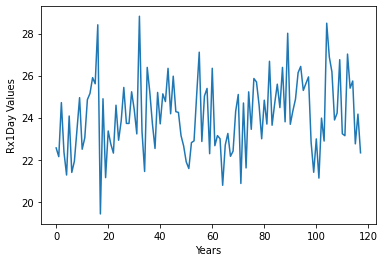

In [74]:
import matplotlib.pyplot as plt
plt.plot(avgYearly)
plt.xlabel('Years')
plt.ylabel('Rx1Day Values')
plt.savefig('./Rx1dayValues.png')
plt.show()

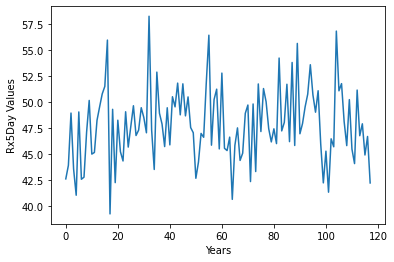

In [75]:
import matplotlib.pyplot as plt
plt.plot(Rx5dayYearly)
plt.xlabel('Years')
plt.ylabel('Rx5Day Values')
plt.savefig('./Rx5dayValues.png')
plt.show()

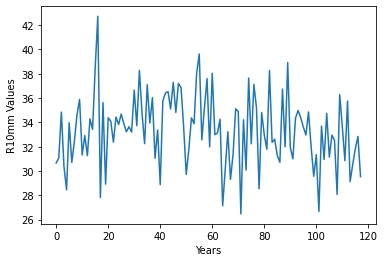

In [76]:
import matplotlib.pyplot as plt
plt.plot(R10mm_yearly)
plt.xlabel('Years')
plt.ylabel('R10mm Values')
plt.savefig('./R10mmValues.png')
plt.show()

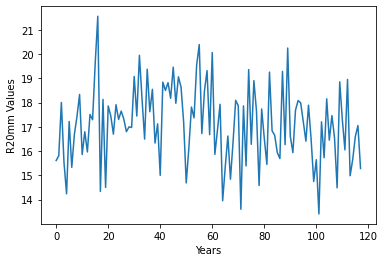

In [77]:
import matplotlib.pyplot as plt
plt.plot(R20mm_yearly)
plt.xlabel('Years')
plt.ylabel('R20mm Values')
plt.savefig('./R20mmValues.png')
plt.show()

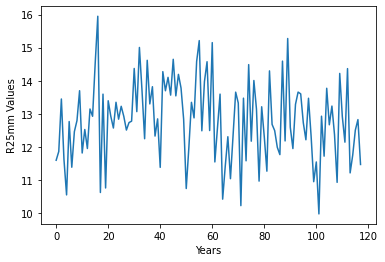

In [78]:
import matplotlib.pyplot as plt
plt.plot(R25mm_yearly)
plt.xlabel('Years')
plt.ylabel('R25mm Values')
plt.savefig('./R25mmValues.png')
plt.show()

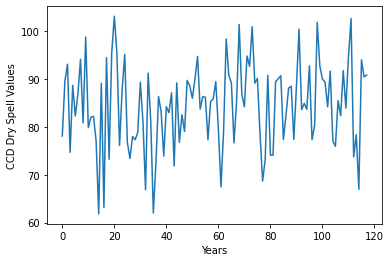

In [79]:
import matplotlib.pyplot as plt
plt.plot(CCD_dryYearly)
plt.xlabel('Years')
plt.ylabel('CCD Dry Spell Values')
plt.savefig('./CCDValues.png')
plt.show()

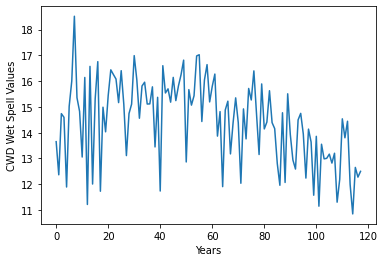

In [80]:
import matplotlib.pyplot as plt
plt.plot(CWD_wetYearly)
plt.xlabel('Years')
plt.ylabel('CWD Wet Spell Values')
plt.savefig('./CWDValues.png')
plt.show()

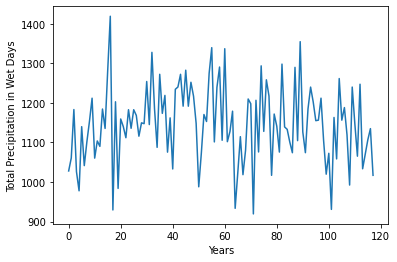

In [81]:
  import matplotlib.pyplot as plt
plt.plot(Prcptot_yearly)
plt.xlabel('Years')
plt.ylabel('Total Precipitation in Wet Days')
plt.savefig('./PRCPTOTValues.png')
plt.show()

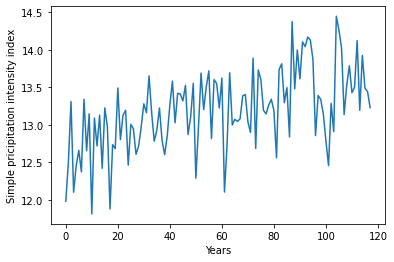

In [82]:
import matplotlib.pyplot as plt
plt.plot(SDII_yearly)
plt.xlabel('Years')
plt.ylabel('Simple pricipitation intensity index')
plt.savefig('./SDIIValues.png')
plt.show()

In [0]:
import matplotlib.pyplot as plt
plt.plot(R95pTOT_yearly)
plt.xlabel('Years')
plt.ylabel('Annual total PRCP when RR > 95p')
plt.savefig('./R95pTOTValues.png')
plt.show()

In [0]:
import matplotlib.pyplot as plt
plt.plot(R99pTOT_yearly)
plt.xlabel('Years')
plt.ylabel('Annual total PRCP when RR > 99p')
plt.savefig('./R99pTOTValues.png')
plt.show()

In [0]:
with open('./Rx1dayvalues.txt', 'w') as file_handler:
    for item in Rx1day:
        file_handler.write("{}\n".format(item))

In [0]:
with open('./Rx5dayvalues.txt', 'w') as file_handler:
    for item in Rx5day:
        file_handler.write("{}\n".format(item))

In [0]:
with open('./R10mmvalues.txt', 'w') as file_handler:
    for item in R10mm:
        file_handler.write("{}\n".format(item))

In [0]:
with open('./PRCPTOTvalues.txt', 'w') as file_handler:
    for item in PRCPTOT:
        file_handler.write("{}\n".format(item))

In [0]:
with open('./SDII.txt', 'w') as file_handler:
    for item in SDII:
        file_handler.write("{}\n".format(item))

In [0]:
with open('./Dryspellvalues.txt', 'w') as file_handler:
    for item in drySpell:
        file_handler.write("{}\n".format(item))

with open('./Wetspellvalues.txt', 'w') as file_handler:
    for item in wetSpell:
        file_handler.write("{}\n".format(item))

In [0]:
with open('./95_percentile_values.txt', 'w') as file_handler:
    for item in total_95:
        file_handler.write("{}\n".format(item))

with open('./99_percentile_values.txt', 'w') as file_handler:
    for item in total_99:
        file_handler.write("{}\n".format(item))